Epoch 1/20
57/57 [==============================] - 5s 12ms/step - loss: 6.6374e-05 - val_loss: 9.0340e-06
Epoch 2/20
57/57 [==============================] - 0s 6ms/step - loss: 2.3823e-06 - val_loss: 7.9197e-06
Epoch 3/20
57/57 [==============================] - 0s 7ms/step - loss: 2.0886e-06 - val_loss: 7.5408e-06
Epoch 4/20
57/57 [==============================] - 0s 7ms/step - loss: 1.9622e-06 - val_loss: 7.6231e-06
Epoch 5/20
57/57 [==============================] - 0s 6ms/step - loss: 1.9515e-06 - val_loss: 8.2459e-06
Epoch 6/20
57/57 [==============================] - 0s 7ms/step - loss: 1.9414e-06 - val_loss: 7.5265e-06
Epoch 7/20
57/57 [==============================] - 0s 6ms/step - loss: 1.9673e-06 - val_loss: 7.9100e-06
Epoch 8/20
57/57 [==============================] - 0s 6ms/step - loss: 1.9669e-06 - val_loss: 7.8194e-06
Epoch 9/20
57/57 [==============================] - 0s 6ms/step - loss: 1.8398e-06 - val_loss: 6.9516e-06
Epoch 10/20
57/57 [==========================

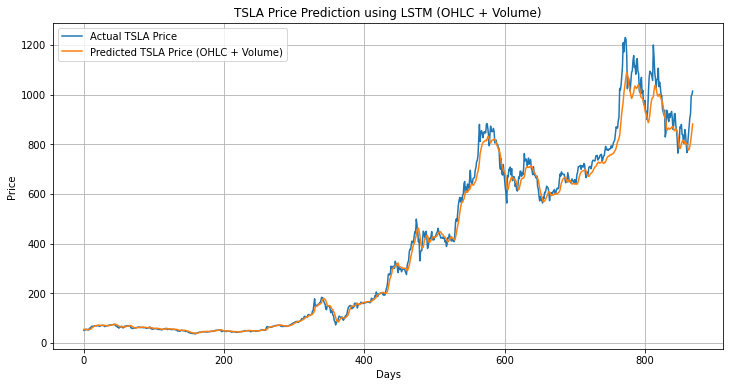

Epoch 1/20
57/57 [==============================] - 1s 9ms/step - loss: 2.8871e-04 - val_loss: 1.4032e-05
Epoch 2/20
57/57 [==============================] - 0s 5ms/step - loss: 5.6342e-06 - val_loss: 1.0245e-05
Epoch 3/20
57/57 [==============================] - 0s 6ms/step - loss: 3.0052e-06 - val_loss: 7.5835e-06
Epoch 4/20
57/57 [==============================] - 0s 6ms/step - loss: 2.5488e-06 - val_loss: 7.2853e-06
Epoch 5/20
57/57 [==============================] - 0s 7ms/step - loss: 2.2817e-06 - val_loss: 6.9937e-06
Epoch 6/20
57/57 [==============================] - 0s 8ms/step - loss: 2.1989e-06 - val_loss: 8.1115e-06
Epoch 7/20
57/57 [==============================] - 0s 7ms/step - loss: 2.1358e-06 - val_loss: 7.2161e-06
Epoch 8/20
57/57 [==============================] - 0s 6ms/step - loss: 2.0797e-06 - val_loss: 7.7004e-06
Epoch 9/20
57/57 [==============================] - 0s 6ms/step - loss: 2.1194e-06 - val_loss: 7.0056e-06
Epoch 10/20
57/57 [===========================

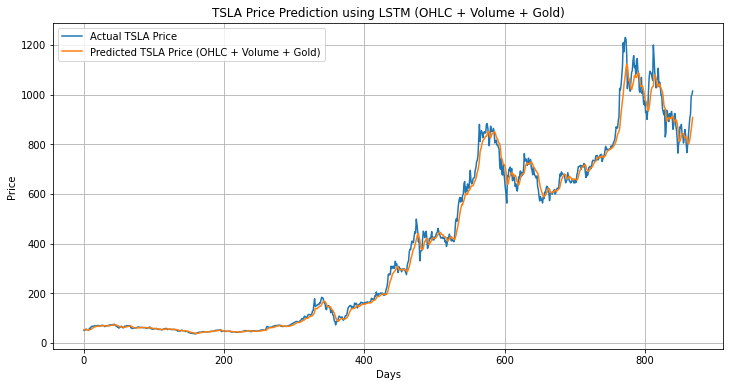

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Input, LayerNormalization, Dropout
from tensorflow.keras.layers import MultiHeadAttention, GlobalAveragePooling1D

#%% LSTM - no gold input

# loading data
df = pd.read_csv("TSLA.csv")
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date")

features = ["Open", "High", "Low", "Close", "Volume"]

# scaling inputs
scaler_input = MinMaxScaler()
scaled_input = scaler_input.fit_transform(df[features])

# scaling output
scaler_target = MinMaxScaler()
scaled_close = scaler_target.fit_transform(df[["Close"]])

# =creating sequences
def create_sequences(data, target, seq_len=60):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i + seq_len])
        y.append(target[i + seq_len])
    return np.array(X), np.array(y)

seq_len = 60
X, y = create_sequences(scaled_input, scaled_close, seq_len)


split = int(0.7 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# building lstm model
model = Sequential()
model.add(LSTM(50, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mean_squared_error")

# training
early_stop = EarlyStopping(monitor="val_loss", patience=5)
model.fit(X_train, y_train, validation_split=0.1, epochs=20,
          batch_size=32, callbacks=[early_stop], verbose=1)

# prediction and plotting
predicted = model.predict(X_test)
predicted_prices = scaler_target.inverse_transform(predicted)
actual_prices = scaler_target.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label="Actual TSLA Price")
plt.plot(predicted_prices, label="Predicted TSLA Price (OHLC + Volume)")
plt.title("TSLA Price Prediction using LSTM (OHLC + Volume)")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


#%% LSTM with gold input

# loading data
tsla_df = pd.read_csv("TSLA.csv")
tsla_df["Date"] = pd.to_datetime(tsla_df["Date"])
tsla_df = tsla_df.sort_values("Date")

# loading gold data
gold_df = pd.read_csv("XAU_USD Historical Data.csv")
gold_df["Date"] = pd.to_datetime(gold_df["Date"], format="%m/%d/%Y")
gold_df["Price"] = gold_df["Price"].str.replace(",", "").astype(float)
gold_df = gold_df.sort_values("Date").rename(columns={"Price": "Gold"})

# merging dfs on date
merged_df = pd.merge(tsla_df, gold_df[["Date", "Gold"]], on="Date", how="inner")

feature_cols = ["Open", "High", "Low", "Close", "Volume", "Gold"]
target_col = "Close"

# scaling input and target
scaler_input = MinMaxScaler()
scaled_inputs = scaler_input.fit_transform(merged_df[feature_cols])

scaler_target = MinMaxScaler()
scaled_target = scaler_target.fit_transform(merged_df[[target_col]])

def create_multivariate_sequences(data, target, seq_len=60):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(target[i+seq_len])
    return np.array(X), np.array(y)

seq_len = 60
X, y = create_multivariate_sequences(scaled_inputs, scaled_target, seq_len)


split = int(0.7 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# building lstm model
model = Sequential()
model.add(LSTM(50, input_shape=(X.shape[1], X.shape[2])))
model.add(Dense(1))
model.compile(optimizer="adam", loss="mean_squared_error")

# training
early_stop = EarlyStopping(monitor="val_loss", patience=5)
model.fit(X_train, y_train, validation_split=0.1, epochs=20,
          batch_size=32, callbacks=[early_stop], verbose=1)

# prediction and plotting
predicted = model.predict(X_test)
predicted_prices = scaler_target.inverse_transform(predicted)
actual_prices = scaler_target.inverse_transform(y_test.reshape(-1, 1))

plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label="Actual TSLA Price")
plt.plot(predicted_prices, label="Predicted TSLA Price (OHLC + Volume + Gold)")
plt.title("TSLA Price Prediction using LSTM (OHLC + Volume + Gold)")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


## Results
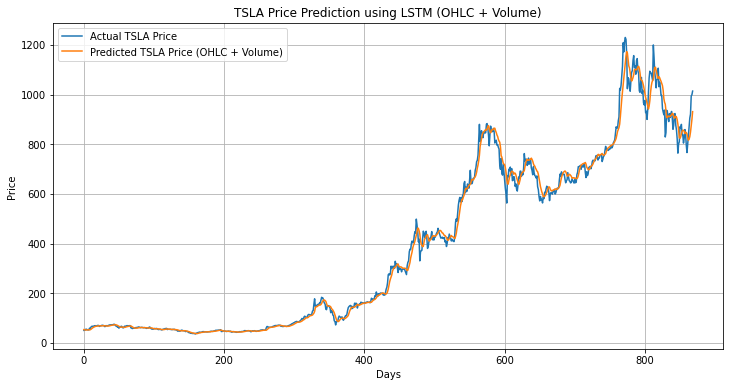 \\
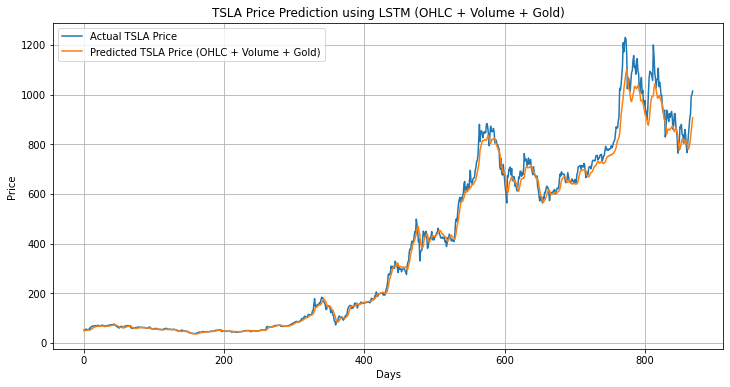 \\
Plots above show the predictions of the LSTM model without and with gold prices as additional input.

## Comments
LSTM handles stock price prediction acceptably but overshoots in certain dates. Using gold as additional input aids in mitigating this overshooting.



Part 2: Transformer

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 30, 5)]      0                                            
__________________________________________________________________________________________________
tf.compat.v1.shape_1 (TFOpLambd (3,)                 0           input_1[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_1 (Sli ()                   0           tf.compat.v1.shape_1[0][0]       
__________________________________________________________________________________________________
tf.range_1 (TFOpLambda)         (None,)              0           tf.__operators__.getitem_1[0][0] 
______________________________________________________________________________________________

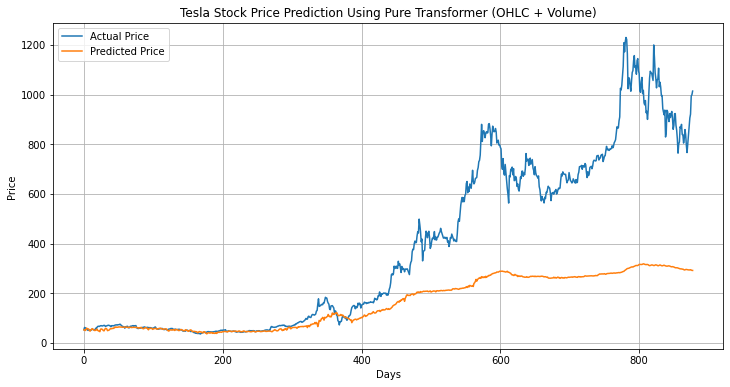

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 30, 6)]      0                                            
__________________________________________________________________________________________________
tf.compat.v1.shape_4 (TFOpLambd (3,)                 0           input_2[0][0]                    
__________________________________________________________________________________________________
tf.__operators__.getitem_6 (Sli ()                   0           tf.compat.v1.shape_4[0][0]       
__________________________________________________________________________________________________
tf.range_3 (TFOpLambda)         (None,)              0           tf.__operators__.getitem_6[0][0] 
____________________________________________________________________________________________

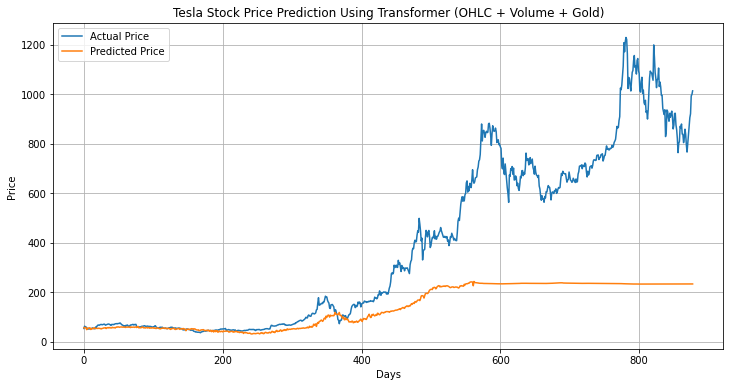

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

# transformer - no gold input

# load data
tsla_df = pd.read_csv("TSLA.csv")
tsla_df["Date"] = pd.to_datetime(tsla_df["Date"])
tsla_df = tsla_df.sort_values("Date")

# input features
feature_cols = ["Open", "High", "Low", "Close", "Volume"]
input_scaler = MinMaxScaler()
scaled_input = input_scaler.fit_transform(tsla_df[feature_cols])

# target
target_scaler = MinMaxScaler()
scaled_target = target_scaler.fit_transform(tsla_df[["Close"]])


seq_len = 30
X, y = [], []
for i in range(seq_len, len(scaled_input)):
    X.append(scaled_input[i - seq_len:i])
    y.append(scaled_target[i, 0])
X = np.array(X)
y = np.array(y)


split = int(0.7 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# positional encoding
def add_positional_encoding(x):
    pos = tf.range(start=0, limit=tf.shape(x)[1], delta=1)
    i = tf.range(start=0, limit=tf.shape(x)[2], delta=1)
    angle_rates = 1 / tf.pow(10000.0, (2 * (tf.cast(i, tf.float32) // 2)) / tf.cast(tf.shape(x)[2], tf.float32))
    angle_rads = tf.cast(pos, tf.float32)[:, tf.newaxis] * angle_rates[tf.newaxis, :]

    sines = tf.sin(angle_rads)
    cosines = tf.cos(angle_rads)
    pos_encoding = tf.where(tf.cast(i % 2 == 0, tf.bool), sines, cosines)
    pos_encoding = tf.expand_dims(pos_encoding, axis=0)
    return x + pos_encoding

# transformer encoder block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x + inputs)

    x_ff = layers.Dense(ff_dim, activation="relu")(x)
    x_ff = layers.Dense(inputs.shape[-1])(x_ff)
    x = layers.Dropout(dropout)(x_ff)
    return layers.LayerNormalization(epsilon=1e-6)(x + x_ff)

# building model (pure transformer)
inputs = keras.Input(shape=(X_train.shape[1], X_train.shape[2]))  # (30, 5)
x = add_positional_encoding(inputs)
x = transformer_encoder(x, head_size=64, num_heads=2, ff_dim=128, dropout=0.1)
x = transformer_encoder(x, head_size=64, num_heads=2, ff_dim=128, dropout=0.1)
x = transformer_encoder(x, head_size=64, num_heads=2, ff_dim=128, dropout=0.1)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])
model.summary()

# training
history = model.fit(X_train, y_train, validation_split=0.1, epochs=100, batch_size=32)

# prediction and inverse transform
predicted = model.predict(X_test)
predicted_prices = target_scaler.inverse_transform(predicted)[:, 0]
actual_prices = target_scaler.inverse_transform(y_test.reshape(-1, 1))[:, 0]

# plotting
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label="Actual Price")
plt.plot(predicted_prices, label="Predicted Price")
plt.title("Tesla Stock Price Prediction Using Pure Transformer (OHLC + Volume)")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

#%% transformer with gold input

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

# loading data
tsla_df = pd.read_csv("TSLA.csv")
tsla_df["Date"] = pd.to_datetime(tsla_df["Date"])
tsla_df = tsla_df.sort_values("Date")

gold_df = pd.read_csv("XAU_USD Historical Data.csv")
gold_df["Date"] = pd.to_datetime(gold_df["Date"], format="%m/%d/%Y")
gold_df["Price"] = gold_df["Price"].str.replace(",", "").astype(float)
gold_df = gold_df.sort_values("Date")

# merging dfs on date
merged_df = pd.merge(tsla_df, gold_df[["Date", "Price"]], on="Date", how="inner")
merged_df.rename(columns={"Price": "Gold_Price"}, inplace=True)


feature_cols = ["Open", "High", "Low", "Close", "Volume", "Gold_Price"]

input_scaler = MinMaxScaler()
scaled_input = input_scaler.fit_transform(merged_df[feature_cols])

target_scaler = MinMaxScaler()
scaled_target = target_scaler.fit_transform(merged_df[["Close"]])


seq_len = 30
X, y = [], []
for i in range(seq_len, len(scaled_input)):
    X.append(scaled_input[i - seq_len:i])  # 30 timesteps
    y.append(scaled_target[i, 0])          # close price target

X = np.array(X)  # shape: (samples, 30, 6)
y = np.array(y)


split = int(0.7 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# positional encoding
def add_positional_encoding(x):
    pos = tf.range(start=0, limit=tf.shape(x)[1], delta=1)
    i = tf.range(start=0, limit=tf.shape(x)[2], delta=1)
    angle_rates = 1 / tf.pow(10000.0, (2 * (tf.cast(i, tf.float32) // 2)) / tf.cast(tf.shape(x)[2], tf.float32))
    angle_rads = tf.cast(pos, tf.float32)[:, tf.newaxis] * angle_rates[tf.newaxis, :]

    sines = tf.sin(angle_rads)
    cosines = tf.cos(angle_rads)
    pos_encoding = tf.where(tf.cast(i % 2 == 0, tf.bool), sines, cosines)
    pos_encoding = tf.expand_dims(pos_encoding, axis=0)
    return x + pos_encoding

# transformer encoder
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x + inputs)

    x_ff = layers.Dense(ff_dim, activation="relu")(x)
    x_ff = layers.Dense(inputs.shape[-1])(x_ff)
    x = layers.Dropout(dropout)(x_ff)
    return layers.LayerNormalization(epsilon=1e-6)(x + x_ff)

# building model
inputs = keras.Input(shape=(X_train.shape[1], X_train.shape[2]))  # (30, 6)
x = add_positional_encoding(inputs)
x = transformer_encoder(x, head_size=64, num_heads=2, ff_dim=128, dropout=0.1)
x = transformer_encoder(x, head_size=64, num_heads=2, ff_dim=128, dropout=0.1)
x = transformer_encoder(x, head_size=64, num_heads=2, ff_dim=128, dropout=0.1)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(64, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(1)(x)

model = keras.Model(inputs, outputs)
optimizer = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])
model.summary()

# training
model.fit(X_train, y_train, validation_split=0.1, epochs=100, batch_size=32)

# prediction and inverse transform
predicted = model.predict(X_test)
predicted_prices = target_scaler.inverse_transform(predicted)[:, 0]
actual_prices = target_scaler.inverse_transform(y_test.reshape(-1, 1))[:, 0]

# results
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label="Actual Price")
plt.plot(predicted_prices, label="Predicted Price")
plt.title("Tesla Stock Price Prediction Using Transformer (OHLC + Volume + Gold)")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

## Results
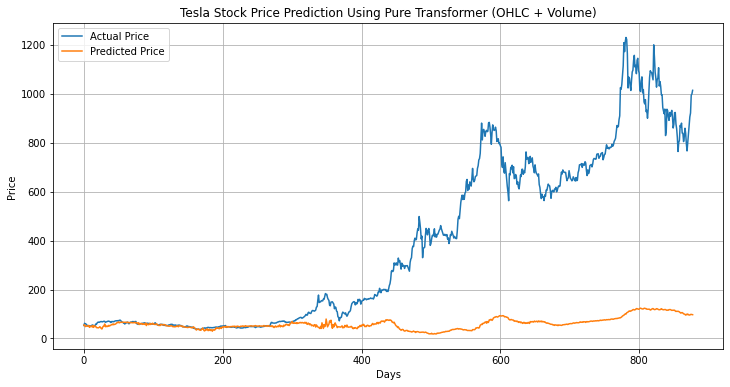 \\
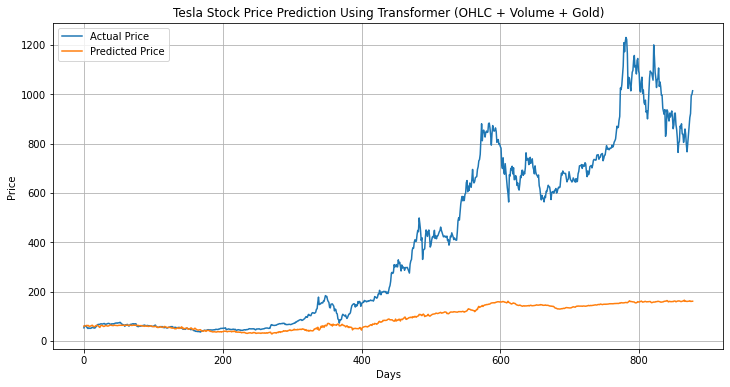 \\
Plots above show the predictions of the transformer model without and with gold prices as additional input.

## Comments
The transformer model was not able to do stock price prediction well, which can be due to the transformer's requirement of larger datasets or longer windows. Adding gold prices as additional input were able to make the predictions closer to the actual values.